# Phonon properties

In [1]:
import numpy as np
from ase.io import read
from calorine.calculators import CPUNEP
from calorine.tools import get_force_constants, relax_structure
from matplotlib import pyplot as plt
from pandas import DataFrame
from phonopy.units import THzToCm
from seekpath import get_explicit_k_path

In this tutorial we illustrate the calculation of phonon dispersions and densities of states.
First, we compute the phonon dispersion of the orthorhombic phase of CsPbI<sub>3</sub> described by a neuroevolution potential using the `get_force_constants()` convenience function from `calorine`, which wraps functionality from the [phonopy package](https://phonopy.github.io/phonopy).
To set the path through the Brillouin zone we use the [seekpath package](https://www.materialscloud.org/work/tools/seekpath).

Then we demonstrate how to use the Python API of `phonopy` directly to compute the phonon density of states.

All models and structures required for running this and the other tutorial notebooks can be obtained from [Zenodo](https://zenodo.org/record/10658778).
The files are also available in the `tutorials/` folder in the [GitLab repository](https://gitlab.com/materials-modeling/calorine/-/tree/master/tutorials).

## Structure preparation

To begin with, we load the orthorhombic CsPbI<sub>3</sub> perovskite structure from file, prepare the calculator object to be used throughout this tutorial, and relax the structure to high precision.

In [2]:
structure = read('CsPbI3-orthorhombic-Pnma.xyz')
calculator = CPUNEP('nep-CsPbI3-SCAN.txt')
structure.calc = calculator
relax_structure(structure, fmax=0.0001)

## Compute force constants

Next we prepare the force constants from which we can then obtain, for example, the phonon dispersion and the phonon density of states as shown below.
To this end, we use the `get_force_constants()` function.
Note that the third argument of this function specifies the supercell that is being used for computing the force constant matrix.
Here, we simply use a $2\times2\times2$ supercell.
In general you need to ensure that the results are converged with respect to the supercell size.

In [3]:
phonon = get_force_constants(structure, calculator, [2, 2, 2])

The `get_force_constants` function returns a [Phonopy object](https://phonopy.github.io/phonopy/phonopy-module.html), which provides methods for calculating various derived quantities, including but not limited to the phonon dispersion and density of states.

## Phonon dispersion

We now need to specify the path through the Brillouin zone along which the phonon dispersion is to be calculated.
To this end, we use the [seekpath package](https://www.materialscloud.org/work/tools/seekpath), which provides a standardized way for generating such paths.
It is also possible to set up suitable paths also "manually" by stringing together a list of $\boldsymbol{q}$-points.

In the following, we first prepare the structure in the format expected by `seekpath` and then call the `get_explicit_k_path` function.

Note that the $\boldsymbol{q}$-points returned by `seekpath` may refer to a different standardize primitive cell, for more information see the documentation of `get_explicit_k_path`.

In [4]:
structure_tuple = (structure.cell, structure.get_scaled_positions(), structure.numbers)
path = get_explicit_k_path(structure_tuple)

First we use the `run_band_structure` method of the `phonon` object to set the path, followed by a call to the `get_band_structure_dict` method to, which returns the actual dispersion.

Note that the `run_band_structure` method expects a *list* of paths, which allows one to specify several non-contiguous segments.
Since the `run_band_structure` function returns *one* set of $\boldsymbol{q}$-points, we therefore need to enclose it in a list, i.e., `[<path>]`.

In [5]:
phonon.run_band_structure([path['explicit_kpoints_rel']])
band = phonon.get_band_structure_dict()

The `get_band_structure_dict` method returns a dict the information in which we can in principle already plot directly.
It can, however, be convenient to handle the information via a pandas `DataFrame` object.
This is accomplished by the following commands, where the second one specifically adds the linear $\boldsymbol{q}$-point coordinates from the path provided by `seekpath`.

In [6]:
df = DataFrame(band['frequencies'][0])
df.index = path['explicit_kpoints_linearcoord']

Finally, we can plot the phonon dispersion.
The most intricate task is to add the labels for the high-symmetry $\boldsymbol{q}$-points, which accounts for most of the lines in the next cell.

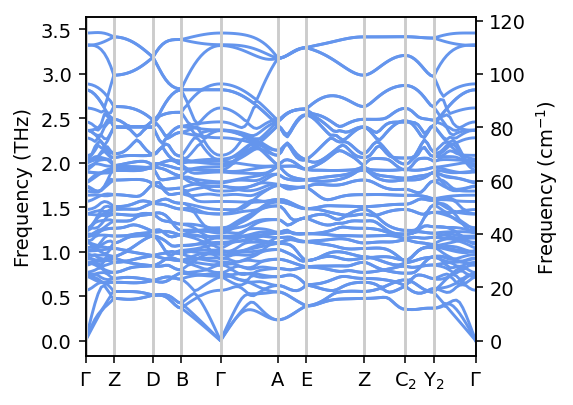

In [7]:
fig, ax = plt.subplots(figsize=(4.2, 3), dpi=140)

for col in df.columns:
    ax.plot(df.index, df[col], color='cornflowerblue')
ax.set_xlim(df.index.min(), df.index.max())

ax.set_ylabel('Frequency (THz)')
ax2 = ax.twinx()
ax2.set_ylabel('Frequency (cm$^{-1}$)')
ax2.set_ylim(THzToCm * np.array(ax.get_ylim()))

# beautify the labels on the x-axis
labels = path['explicit_kpoints_labels']
labels = ['$\Gamma$' if m == 'GAMMA' else m for m in labels]
labels = [m.replace('_', '$_') + '$' if '_' in m else m for m in labels]
df_path = DataFrame(dict(labels=labels,
                         positions=path['explicit_kpoints_linearcoord']))
df_path.drop(df_path.index[df_path.labels == ''], axis=0, inplace=True)
ax.set_xticks(df_path.positions)
ax.set_xticklabels(df_path.labels)
for xp in df_path.positions:
    ax.axvline(xp, color='0.8')

plt.tight_layout()

## Density of states

Next we compute the density of states, which requires sampling the frequencies over a mesh of $\boldsymbol{q}$-points that sample the Brillouin zone.
This is accomplished via the `run_mesh` method, where the argument specifies the $\boldsymbol{q}$-point density.
Subsequently we can readily extract the density of states in the form of a `dict`.

In [8]:
phonon.run_mesh(140)
phonon.run_total_dos(freq_min=-0.1, freq_max=3.7, freq_pitch=0.02)
dos = phonon.get_total_dos_dict()

Finally, we plot the total density of states.

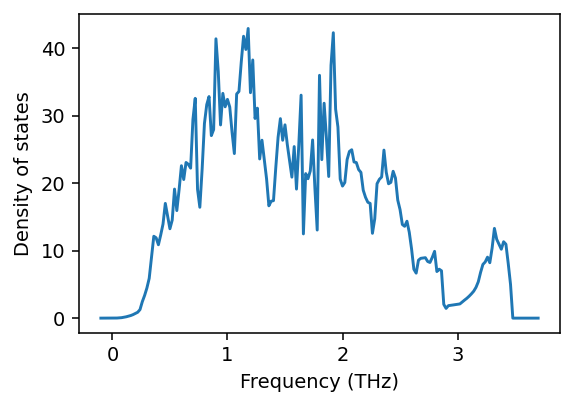

In [9]:
fig, ax = plt.subplots(figsize=(4.2, 3), dpi=140)

ax.plot(dos['frequency_points'], dos['total_dos'])
ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Density of states')

plt.tight_layout()